# k Nearest Neighbor

In [ ]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
#from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
import nibabel as nib
from nilearn import plotting as plotting
import glob

In [ ]:
def binaryze_mask(in_file, out_file):
    from nipype.interfaces.fsl.maths import UnaryMaths
    binaryze_mask = UnaryMaths()
    binaryze_mask.inputs.in_file = in_file
    binaryze_mask.inputs.operation = 'bin'
    binaryze_mask.inputs.out_file = out_file
    #print(binaryze_mask.cmdline)
    binaryze_mask.run()
    return out_file

def thrp_mask(in_file, out_file, thr):
    from nipype.interfaces.fsl.maths import Threshold
    thrp_mask = Threshold()
    thrp_mask.inputs.in_file = in_file
    thrp_mask.inputs.thresh = int(thr)
    thrp_mask.inputs.use_robust_range = True
    thrp_mask.inputs.out_file = out_file
    print(thrp_mask.cmdline)
    thrp_mask.run()
    return out_file

In [ ]:
os.getcwd()

In [ ]:
data_folder = '../20190801'

## Extract data from preprocessed niftis and store them in concatenated numpy arrays

In [184]:
train_subjects = ['SMART005', 'SMART008', 'SMART010']

In [185]:
flairs = glob.glob(data_folder + '/SMART0*/flair/SMART0*.flair_ro_n4_2t1Warped_brain.nii.gz')

In [186]:
t1s = glob.glob(data_folder + '/SMART0*/anat/SMART0*.anat_ro_n4_optiBET_brain.nii.gz')

In [187]:
les = [data_folder + '/SMART005/flair/ples_lpa_mSMART005.flair_ro_n4_2t1Warped.nii',
      data_folder + '/SMART008/flair/ples_lpa_mSMART008.flair_ro_n4_2t1Warped.nii',
      data_folder + '/SMART010/flair/ples_lpa_mSMART010.flair_ro_n4_2t1Warped.nii']
#les_bin = [data_folder + '/SMART005/flair/ples_lpa_mSMART005.flair_ro_n4_2t1Warped_bin.nii.gz',
#      data_folder + '/SMART008/flair/ples_lpa_mSMART008.flair_ro_n4_2t1Warped_bin.nii.gz',
#      data_folder + '/SMART010/flair/ples_lpa_mSMART010.flair_ro_n4_2t1Warped_bin.nii.gz']

In [188]:
[os.path.isfile(i) for i in les]

[True, True, True]

In [189]:
les_thr = [i for i in [thrp_mask(j, '..' + j.strip('.nii') + '_thrp80.nii.gz', 80) for j in les]]

fslmaths ../20190801/SMART005/flair/ples_lpa_mSMART005.flair_ro_n4_2t1Warped.nii -thrp 80.0000000000 ../20190801/SMART005/flair/ples_lpa_mSMART005.flair_ro_n4_2t1Warped_thrp80.nii.gz
fslmaths ../20190801/SMART008/flair/ples_lpa_mSMART008.flair_ro_n4_2t1Warped.nii -thrp 80.0000000000 ../20190801/SMART008/flair/ples_lpa_mSMART008.flair_ro_n4_2t1Warped_thrp80.nii.gz
fslmaths ../20190801/SMART010/flair/ples_lpa_mSMART010.flair_ro_n4_2t1Warped.nii -thrp 80.0000000000 ../20190801/SMART010/flair/ples_lpa_mSMART010.flair_ro_n4_2t1Warped_thrp80.nii.gz


In [190]:
les_bin = [i for i in [binaryze_mask(j, '..' + j.strip('.nii.gz') + '_thrp80_bin.nii.gz') for j in les_thr]]

In [191]:
#print(flairs)
#print(t1s)
#print(les)

In [192]:
 [os.path.isfile(i) for i in t1s ]

[True, True, True]

## Plotting

In [95]:
#plotting.plot_anat(wm_t1s[0], display_mode = 'z', black_bg = False)

In [96]:
#plotting.plot_anat(wm_flairs[0], display_mode = 'z', black_bg = False)

In [79]:
#plotting.plot_roi(les[0], wm_flairs[0], display_mode = 'z', cmap='Paired', black_bg = False)

# Open and Concatenate data

In [193]:
t1_values = np.concatenate(tuple([nib.load(i).get_data() for i in t1s]))
flair_values = np.concatenate(tuple([nib.load(i).get_data() for i in flairs]))
les_values = np.concatenate(tuple([nib.load(i).get_data() for i in les_bin]))


In [194]:
t1_values.shape

(576, 256, 256)

In [195]:
t1_values.shape == flair_values.shape == les_values.shape

True

In [157]:
np.argwhere(np.isnan(les_values))

array([], shape=(0, 3), dtype=int64)

## Mean Normalization

In [196]:
nt1= t1_values / np.mean(t1_values[np.nonzero(t1_values)])
nflair = flair_values / np.mean(flair_values[np.nonzero(flair_values)])

## Organize Data in Pandas DataFrame

In [209]:
df = pd.DataFrame.from_dict({'t1':list(nt1.reshape(-1)), 'flair':list(nflair.reshape(-1)), 'les':list(les_values.reshape(-1))})

In [210]:
df_nonzero = df[(df.t1 != 0 ) & (df.flair != 0)]

In [218]:
df_nonzero.head()

,t1,flair,les
1925747,0.106620,0.021551,0.0
1925748,0.268653,0.006080,0.0
1925749,0.307017,0.014655,0.0
1925751,0.277199,0.040898,0.0
1926001,0.123689,0.108057,0.0


In [215]:
# Input is every column but the les
X = df_nonzero.drop(columns=['les'])

In [216]:
X.head()

,t1,flair
1925747,0.106620,0.021551
1925748,0.268653,0.006080
1925749,0.307017,0.014655
1925751,0.277199,0.040898
1926001,0.123689,0.108057


In [225]:
y = df_nonzero.les

In [226]:
## Split the dataset into train and test data

In [289]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
## Building and training the model

In [232]:
%%time
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 100, n_jobs=7)

# Fit the classifier to the data
knn.fit(X,y)

CPU times: user 6.13 s, sys: 66.4 ms, total: 6.2 s
Wall time: 6.18 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=7, n_neighbors=100, p=2,
                     weights='uniform')

In [230]:
%%time
knn.predict(X_test)

CPU times: user 1min 5s, sys: 1.47 s, total: 1min 7s
Wall time: 34.3 s


array([0., 0., 0., ..., 0., 0., 0.])

In [231]:
knn.score(X_test, y_test)

0.9979728934379782

In [291]:
%%time
scores = dict()
for k in range(5,101,5):
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs=7)
    knn.fit(X_train,y_train)
    knn.predict(X_test)
    scores[k] = knn.score(X_test, y_test)

CPU times: user 35min 44s, sys: 30.9 s, total: 36min 15s
Wall time: 22min 53s


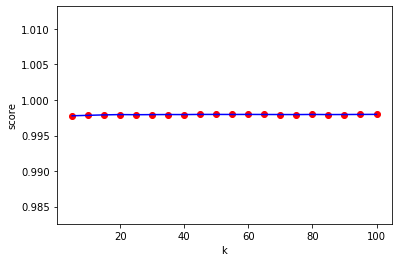

In [293]:
lists = sorted(scores.items())
x,y = zip(*lists)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, marker = 'o', c = 'r')
ax.plot(x, y, c='b')
ax.set_xlabel('k')
ax.set_ylabel('score')
plt.show()

# Build Test DataSet

In [247]:
test_subjects = ['SMART004', 'SMART007']

In [248]:
flairs = [data_folder + '/{0}/flair/{0}.flair_ro_n4_2t1Warped_brain.nii.gz'.format(i) for i in test_subjects ] 

In [249]:
t1s = [data_folder + '/{0}/anat/{0}.anat_ro_n4_optiBET_brain.nii.gz'.format(i) for i in test_subjects ] 

In [272]:
les = [data_folder + '/{0}/flair/ples_lpa_m{0}.flair_ro_n4_2t1Warped.nii'.format(i) for i in test_subjects]
les_thr = [i for i in [thrp_mask(j, '..' + j.strip('.nii') + '_thrp80.nii.gz', 80) for j in les]]
les_bin = [i for i in [binaryze_mask(j, '..' + j.strip('.nii.gz') + '_thrp80_bin.nii.gz') for j in les_thr]]

fslmaths ../20190801/SMART004/flair/ples_lpa_mSMART004.flair_ro_n4_2t1Warped.nii -thrp 80.0000000000 ../20190801/SMART004/flair/ples_lpa_mSMART004.flair_ro_n4_2t1Warped_thrp80.nii.gz
fslmaths ../20190801/SMART007/flair/ples_lpa_mSMART007.flair_ro_n4_2t1Warped.nii -thrp 80.0000000000 ../20190801/SMART007/flair/ples_lpa_mSMART007.flair_ro_n4_2t1Warped_thrp80.nii.gz


In [273]:
test_t1_values = np.concatenate(tuple([nib.load(i).get_data() for i in t1s]))
test_flair_values = np.concatenate(tuple([nib.load(i).get_data() for i in flairs]))
test_les_values = np.concatenate(tuple([nib.load(i).get_data() for i in les_bin]))

In [251]:
test_nt1= test_t1_values / np.mean(test_t1_values[np.nonzero(test_t1_values)])
test_nflair = test_flair_values / np.mean(test_flair_values[np.nonzero(test_flair_values)])

In [275]:
test_df = pd.DataFrame.from_dict({'t1':list(test_nt1.reshape(-1)), 'flair':list(test_nflair.reshape(-1)), 'les':list(test_les_values.reshape(-1))})
test_df = test_df[(test_df.t1 != 0 ) & (test_df.flair != 0)]

In [276]:
test_df.head()

,t1,flair,les
2187928,0.437730,0.202685,0.0
2187929,0.548742,0.191040,0.0
2188174,0.300309,0.149035,0.0
2188175,0.290746,0.146475,0.0
2188176,0.294400,0.123141,0.0


In [259]:
%%time
prediction = knn.predict(test_df)

CPU times: user 3min 30s, sys: 5.56 s, total: 3min 36s
Wall time: 2min


In [277]:
## Add prediction to DataFrame
test_df['les_prediction'] = prediction

In [278]:
test_df.head()

,t1,flair,les,les_prediction
2187928,0.437730,0.202685,0.0,0.0
2187929,0.548742,0.191040,0.0,0.0
2188174,0.300309,0.149035,0.0,0.0
2188175,0.290746,0.146475,0.0,0.0
2188176,0.294400,0.123141,0.0,0.0


In [279]:
sum(test_df.les.values)

10502.0

In [280]:
sum(test_df.les_prediction.values)

7573.0

In [283]:
len(test_df[(test_df.les == test_df.les_prediction) & ((test_df.les ==1)|(test_df.les_prediction == 1))])

5678

### Plot Intensitites

In [265]:
train_pos = df_nonzero[(df_nonzero.les == 1)].sample(n=100)
train_neg = df_nonzero[(df_nonzero.les == 0)].sample(n=100)

test_pos = test_df[(test_df.les == 1)].sample(100)
test_neg = test_df[(test_df.les == 0)].sample(100)

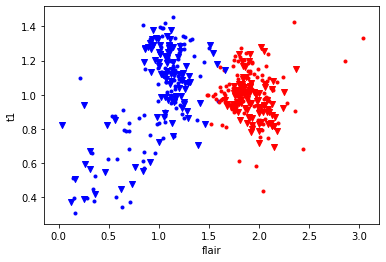

In [271]:
#IND2=np.random.randint(np.shape(t1_tissue)[0], size=flair_les.shape[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_neg.flair, train_neg.t1, marker = '.', c = 'b')
ax.scatter(train_pos.flair, train_pos.t1, marker = '.', c = 'r' )
ax.scatter(test_neg.flair, test_neg.t1, marker = 'v', c = 'b')
ax.scatter(test_pos.flair, test_pos.t1, marker = 'v', c = 'r' )
#ax.scatter(flair_les, t1_les, c='r', marker='^')
ax.set_xlabel('flair')
ax.set_ylabel('t1')
plt.show()

# Save Results

In [177]:
save_path = '../WhiteMatterHyperintensities/Data/train'
np.save(save_path + '/t1_tissue.npy', t1_tissue, allow_pickle=True, fix_imports=True)
np.save(save_path + '/flair_tissue.npy', flair_tissue, allow_pickle=True, fix_imports=True)
np.save(save_path + '/t1_les.npy', t1_les, allow_pickle=True, fix_imports=True)
np.save(save_path + '/flair_les.npy', flair_les, allow_pickle=True, fix_imports=True)